# Machine Learning for Economics
## Peru Project
##          
#### Ramon Gmür 16-705-220
#### Ben Murphy 16-714-925
#### Florian Rüegsegger 14-714-737
### 
#### 1 Data Preprocessing
#### 2 Model training & evaluation

In [64]:
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression,Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

# 1 Data Preprocessing

In [90]:
df2 = pd.read_csv('peru_matlab_export_full.csv')

# drop columns excluded from training dataset
df2.drop(columns=['poor','percapitaconsumption','lncaphat_OLS','percapitahat_OLS','id_for_matlab','hhid','h_hhsize'],inplace=True)

# drop null values
df2.dropna(inplace=True)

# define ranges
data = df2.to_numpy()
NTrain = np.where(data[:,73]==1)[0]
NTest = np.where(data[:,73]==0)[0]

y = data[:,0]
ytrain = y[NTrain]
ytest = y[NTest]

# leave out column 73 (prediction column)
X = data[:,1:73+74]

# select Xtrain
Xtrain = X[NTrain,:]
Xtest = X[NTest,:]

# prepare df for adding stuff like id_for_matlab
df_app = pd.read_csv('peru_matlab_export_full.csv')
df_app.dropna(inplace=True)
df_app = df_app.filter(['poor','percapitaconsumption','lncaphat_OLS','percapitahat_OLS','id_for_matlab','hhid','h_hhsize'])

df2.columns

Index(['lnpercapitaconsumption', 'd_fuel_other', 'd_fuel_wood', 'd_fuel_coal',
       'd_fuel_kerosene', 'd_fuel_gas', 'd_fuel_electric', 'd_fuel_none',
       'd_water_other', 'd_water_river', 'd_water_well', 'd_water_truck',
       'd_water_pylon', 'd_water_outside', 'd_water_inside', 'd_drain_none',
       'd_drain_river', 'd_drain_cesspool', 'd_drain_septic',
       'd_drain_outside', 'd_drain_inside', 'd_wall_other', 'd_wall_woodmat',
       'd_wall_stonemud', 'd_wall_quincha', 'd_wall_tapia', 'd_wall_adobe',
       'd_wall_stonecement', 'd_wall_brickcement', 'd_roof_other',
       'd_roof_straw', 'd_roof_mat', 'd_roof_platecane', 'd_roof_tile',
       'd_roof_wood', 'd_roof_concrete', 'd_floor_other', 'd_floor_earth',
       'd_floor_cement', 'd_floor_wood', 'd_floor_tile', 'd_floor_sheets',
       'd_floor_parquet', 'd_electricity', 'd_telephone', 'd_h_educ_none',
       'd_h_educ_pre', 'd_h_educ_prim', 'd_h_educ_sec',
       'd_h_educ_higher_nouni', 'd_h_educ_higher_uni', 'd_h_

In [91]:
df2

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,training
0,5.351858,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1,0,0,0,0,0,0
1,5.768755,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
2,5.968277,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
3,5.654599,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,1,0,0,0,0,0,0
4,4.771289,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46300,6.146313,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0,0,0,1,0,0,1
46301,5.530832,0,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1,0,0,0,0,0,1
46302,5.965293,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0,1,0,0,0,0,1
46303,4.736676,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,1


# 2 Model Training & Evaluation

In [92]:
# Kfold
def kfold_validation(X,y,model):
    start = time.time()
    kf = KFold(n_splits=5,shuffle=True, random_state=69420) 
    mses = []
    models = []
    count = 0
    for trainIndices,testIndices in kf.split(X):
        print(f"iteration: {count}")
        Xtrain,Xval = X[trainIndices],X[testIndices]
        ytrain,yval = y[trainIndices],y[testIndices]
        model.fit(Xtrain,ytrain)
        yhat = model.predict(Xval)
        mse = np.mean((np.square(yval-yhat)))
        mses.append(mse)
        models.append(model)
        count+=1
    print(f"time used (seconds): {time.time()-start}")
    return mses, models

## Linear Regression

In [93]:

start = time.time()
# set n_jobs=-1 if nothing else is running on pc to use all available cores
model=LinearRegression()
#model.fit(X)
mses,models = kfold_validation(Xtrain,ytrain,model)

print(np.mean(mses))
print(f"time used(s): {time.time()-start}")

best_model = models[np.argmin(mses)]
print(mses[np.argmin(mses)])





iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.1795182228088379
0.19296160097893894
time used(s): 0.18051648139953613
0.18786373589462413


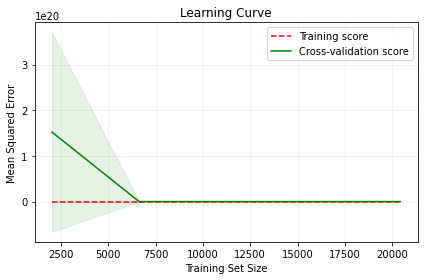

In [96]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), 
                                                        Xtrain, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Ridge

In [99]:
mses = []
models = []
range_min=6 #started with 0
range_max=15
step_size=0.1 #started with 1
for alpha in np.arange(range_min,range_max,step_size):
    print(f"alpha: {alpha}")
    model = Ridge(alpha)
    temp_mses, temp_models = kfold_validation(Xtrain,ytrain,model)
    mses.append(np.mean(temp_mses))
    models.append(temp_models[np.argmin(temp_mses)])
msearray=np.array(mses)
multiplier=np.where(msearray==np.min(msearray))[0][0]
print(f"best alpha: {range_min+multiplier*step_size}")
print(f"MSE at alpha: {msearray[multiplier]}")



alpha: 6.0
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.1007070541381836
alpha: 6.1
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09175395965576172
alpha: 6.199999999999999
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08976078033447266
alpha: 6.299999999999999
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08975982666015625
alpha: 6.399999999999999
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09574389457702637
alpha: 6.499999999999998
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08676838874816895
alpha: 6.599999999999998
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09275245666503906
alpha: 6.6999999999999975
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 

iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09474563598632812
alpha: 12.399999999999977
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08976030349731445
alpha: 12.499999999999977
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09275245666503906
alpha: 12.599999999999977
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.08776617050170898
alpha: 12.699999999999976
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09082317352294922
alpha: 12.799999999999976
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09674072265625
alpha: 12.899999999999975
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.09773516654968262
alpha: 12.999999999999975
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 0.0997

In [100]:
# generate predictions
model = Ridge(alpha=7.6)
model.fit(Xtrain, ytrain)
yhat_ridge = model.predict(X)
df_ridge = pd.DataFrame(yhat_ridge, columns = ["groupprediction2"])

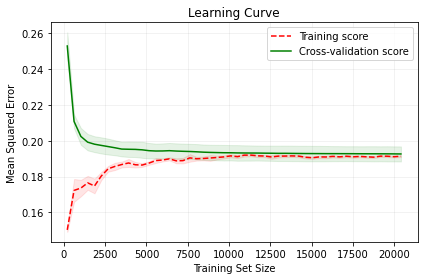

In [101]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(Ridge(), 
                                                        Xtrain, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## SVR

In [102]:
from sklearn.svm import SVR
mses=[]
kernels=["linear","poly","rbf","sigmoid"]
for kernel in kernels:    
    print(kernel)
    model = SVR(kernel)
    temp_mses, temp_models = kfold_validation(Xtrain,ytrain,model)
    mses.append(np.mean(temp_mses))
msearray=np.array(mses)
multiplier=np.where(msearray==np.min(msearray))[0][0]
print(f"best kernel: {kernels[np.argmin(msearray)]}")
print(f"MSE at kernel: {np.min(msearray)}")



linear
iteration: 0


C:\Users\Ramon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 231.8322331905365
poly
iteration: 0


C:\Users\Ramon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=poly as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 296.1881203651428
rbf
iteration: 0


C:\Users\Ramon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 204.578387260437
sigmoid
iteration: 0


C:\Users\Ramon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=sigmoid as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
time used (seconds): 205.80550527572632
best kernel: rbf
MSE at kernel: 0.1915411924007089


In [103]:
# generate predictions
model = SVR(kernel="rbf")
model.fit(Xtrain, ytrain)
yhat_svr = model.predict(X)
df_svr = pd.DataFrame(yhat_svr, columns = ["groupprediction"])

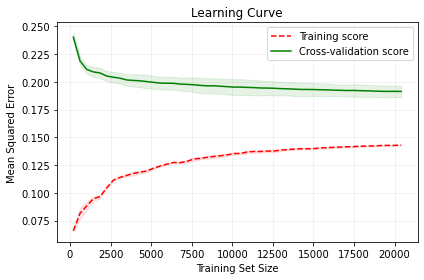

In [104]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVR(kernel="rbf"), 
                                                        Xtrain, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [105]:
# merge data, appendix & predictions

# reset index (otherwise NANs appear again)

df2.reset_index(inplace=True)
df_ridge.reset_index(inplace=True)
df_svr.reset_index(inplace=True)
df_app.reset_index(inplace=True)

# merge dfs & export

df_grouppredictions = pd.concat([df2, df_ridge, df_svr, df_app], axis=1)
df_grouppredictions.to_csv("peru_predictions.csv")

# don't forget to drop index columns